### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [158]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 6.75 s, sys: 42.5 ms, total: 6.79 s
Wall time: 19.1 s


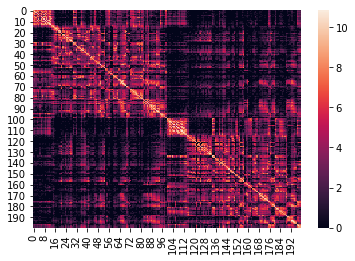

In [13]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [14]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [15]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [16]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.3 s, sys: 587 ms, total: 59.9 s
Wall time: 1min 23s


In [17]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.37 s, sys: 96.4 ms, total: 1.47 s
Wall time: 1.47 s


In [18]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [19]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [20]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 22s, sys: 2.49 s, total: 1min 24s
Wall time: 3min 35s


In [21]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

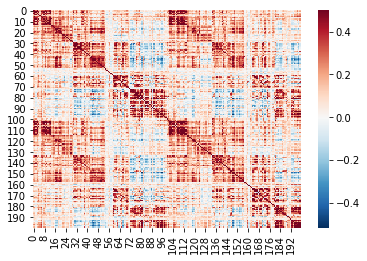

In [22]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

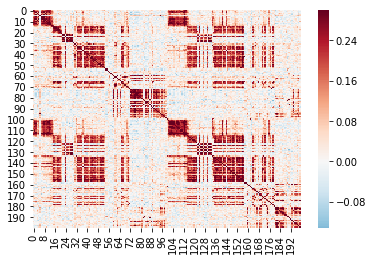

In [23]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [28]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [29]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

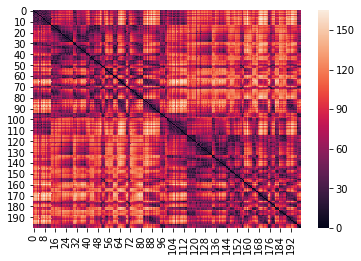

In [30]:
sns.heatmap(distance)

## Communicability

In [555]:
# intact sc

In [548]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 6.47 s, sys: 95.8 ms, total: 6.57 s
Wall time: 6.57 s


In [556]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [560]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

In [559]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 104 ms, sys: 280 ms, total: 385 ms
Wall time: 387 ms


In [ ]:
# lesion sc

In [561]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 45.3 s, sys: 1.02 s, total: 46.3 s
Wall time: 46.6 s


## WITHIN NETWORKS

In [567]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_sc

In [570]:
def within_ntwx_SC_communicability(SC):
    
    # lesion (DMN) whobpyt

    lesion_vis_sc_comm_all_subs = []
    lesion_smt_sc_comm_all_subs = []
    lesion_dan_sc_comm_all_subs = []
    lesion_van_sc_comm_all_subs = []
    lesion_lim_sc_comm_all_subs = []
    lesion_fpn_sc_comm_all_subs = []
    lesion_dmn_sc_comm_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = within_ntwx_SC(SC[i], 0, 14, 100, 115)
        lesion_vis_sc_comm_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = within_ntwx_SC(SC[i], 14, 30, 115, 134)
        lesion_smt_sc_comm_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = within_ntwx_SC(SC[i], 30, 43, 134, 147)
        lesion_dan_sc_comm_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = within_ntwx_SC(SC[i], 43, 54, 147, 158)
        lesion_van_sc_comm_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = within_ntwx_SC(SC[i], 54, 60, 158, 164)
        lesion_lim_sc_comm_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = within_ntwx_SC(SC[i], 60, 73, 164, 181)
        lesion_fpn_sc_comm_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = within_ntwx_SC(SC[i], 73, 100, 181, 200)
        lesion_dmn_sc_comm_all_subs.append(ntwx_lesion_temp_dmn)


    lesion_vis_sc_comm_all_subs_mean = np.mean(lesion_vis_sc_comm_all_subs)
    lesion_smt_sc_comm_all_subs_mean = np.mean(lesion_smt_sc_comm_all_subs)
    lesion_dan_sc_comm_all_subs_mean = np.mean(lesion_dan_sc_comm_all_subs)
    lesion_van_sc_comm_all_subs_mean = np.mean(lesion_van_sc_comm_all_subs)
    lesion_lim_sc_comm_all_subs_mean = np.mean(lesion_lim_sc_comm_all_subs)
    lesion_fpn_sc_comm_all_subs_mean = np.mean(lesion_fpn_sc_comm_all_subs)
    lesion_dmn_sc_comm_all_subs_mean = np.mean(lesion_dmn_sc_comm_all_subs)


    ntwx_lesion_means_all_subs = [lesion_vis_sc_comm_all_subs,lesion_smt_sc_comm_all_subs,
                                  lesion_dan_sc_comm_all_subs,lesion_van_sc_comm_all_subs,
                                  lesion_lim_sc_comm_all_subs,lesion_fpn_sc_comm_all_subs,
                                  lesion_dmn_sc_comm_all_subs]
    
    ntwx_lesion_whobpyt_means = [lesion_vis_sc_comm_all_subs_mean,lesion_smt_sc_comm_all_subs_mean,
                                 lesion_dan_sc_comm_all_subs_mean,lesion_van_sc_comm_all_subs_mean,
                                 lesion_lim_sc_comm_all_subs_mean,lesion_fpn_sc_comm_all_subs_mean,
                                 lesion_dmn_sc_comm_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [573]:
intact_sc_comm_means, intact_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means, vis_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion)
smt_lesion_sc_comm_means, smt_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion)
dan_lesion_sc_comm_means, dan_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion)
van_lesion_sc_comm_means, van_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion)
lim_lesion_sc_comm_means, lim_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion)
fpn_lesion_sc_comm_means, fpn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion)
dmn_lesion_sc_comm_means, dmn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion)

In [684]:
len(vis_lesion_sc_comm_all_subs[0])

200

In [656]:
# print(intact_sc_comm_means)
# print(vis_lesion_sc_comm_means)
# print(smt_lesion_sc_comm_means)
# print(dan_lesion_sc_comm_means)
# print(van_lesion_sc_comm_means)
# print(lim_lesion_sc_comm_means)
# print(fpn_lesion_sc_comm_means)
# print(dmn_lesion_sc_comm_means)

In [580]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [ ]:
def stats_func(all_subs):
    _df = pd.DataFrame(all_subs,index=ntwx_labels)
    _df = _df.T
    

In [581]:
intact_sc_df = pd.DataFrame(intact_sc_comm_all_subs,index=ntwx_labels)
intact_sc_df = intact_sc_df.T

vis_lesion_df = pd.DataFrame(vis_lesion_sc_comm_all_subs,index=ntwx_labels)
vis_lesion_df = vis_lesion_df.T

smt_lesion_df = pd.DataFrame(smt_lesion_sc_comm_all_subs,index=ntwx_labels)
smt_lesion_df = smt_lesion_df.T

dan_lesion_df = pd.DataFrame(dan_lesion_sc_comm_all_subs,index=ntwx_labels)
dan_lesion_df = dan_lesion_df.T

van_lesion_df = pd.DataFrame(van_lesion_sc_comm_all_subs,index=ntwx_labels)
van_lesion_df = van_lesion_df.T


lim_lesion_df = pd.DataFrame(lim_lesion_sc_comm_all_subs,index=ntwx_labels)
lim_lesion_df = lim_lesion_df.T

fpn_lesion_df = pd.DataFrame(fpn_lesion_sc_comm_all_subs,index=ntwx_labels)
fpn_lesion_df = fpn_lesion_df.T

dmn_lesion_df = pd.DataFrame(dmn_lesion_sc_comm_all_subs,index=ntwx_labels)
dmn_lesion_df = dmn_lesion_df.T

#### vis lesion comm stats

In [582]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], vis_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -49.1934089750088
P-Value: 2.974034063349742e-171 

-------------------
Network =  SomMot
T-Statistic: -2.0417720331470828
P-Value: 0.04183297818789593 

-------------------
Network =  DorsAttn
T-Statistic: -14.787149798531658
P-Value: 9.606368850406695e-40 

-------------------
Network =  VentAttn
T-Statistic: -3.8858551641562658
P-Value: 0.00011941347099217674 

-------------------
Network =  Limbic
T-Statistic: -8.905587532135687
P-Value: 1.9129015321346188e-17 

-------------------
Network =  FPN
T-Statistic: -4.7668583492740195
P-Value: 2.6283929703230095e-06 

-------------------
Network =  DMN
T-Statistic: -16.45463127295428
P-Value: 8.812386317603187e-47 

-------------------


####  smt lesion comm stats

In [584]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], smt_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -1.9464559092677347
P-Value: 0.05230329376221893 

-------------------
Network =  SomMot
T-Statistic: -86.74413853168703
P-Value: 1.3046903932859369e-260 

-------------------
Network =  DorsAttn
T-Statistic: -36.37580179917309
P-Value: 1.273064230420407e-128 

-------------------
Network =  VentAttn
T-Statistic: -33.70313697899445
P-Value: 1.17384883503565e-118 

-------------------
Network =  Limbic
T-Statistic: -0.9058541473996038
P-Value: 0.3655611117237312 

-------------------
Network =  FPN
T-Statistic: -10.282188475047517
P-Value: 3.7777976075834195e-22 

-------------------
Network =  DMN
T-Statistic: -10.996134226479143
P-Value: 9.707743081697722e-25 

-------------------


#### dan lesion comm stats

In [585]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], dan_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -15.62713945640526
P-Value: 2.8791597088382385e-43 

-------------------
Network =  SomMot
T-Statistic: -28.308558927321158
P-Value: 2.2566859854785854e-97 

-------------------
Network =  DorsAttn
T-Statistic: -107.4339356791786
P-Value: 4.5872712028369537e-296 

-------------------
Network =  VentAttn
T-Statistic: -16.3240768029323
P-Value: 3.1764913467299344e-46 

-------------------
Network =  Limbic
T-Statistic: -2.7116934959791155
P-Value: 0.006984133351182065 

-------------------
Network =  FPN
T-Statistic: -19.203955465535653
P-Value: 1.2173480099866938e-58 

-------------------
Network =  DMN
T-Statistic: -17.180294983398348
P-Value: 6.858209866135028e-50 

-------------------


#### van lesion comm stats

In [586]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], van_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -2.331514544630397
P-Value: 0.02022462367283138 

-------------------
Network =  SomMot
T-Statistic: -30.253514267627555
P-Value: 3.188601679565319e-105 

-------------------
Network =  DorsAttn
T-Statistic: -14.476401964672723
P-Value: 1.8725163574200252e-38 

-------------------
Network =  VentAttn
T-Statistic: -97.92545399950282
P-Value: 1.2481116228996982e-280 

-------------------
Network =  Limbic
T-Statistic: -2.304565014022141
P-Value: 0.021704992500834585 

-------------------
Network =  FPN
T-Statistic: -16.21406456028586
P-Value: 9.343854529456148e-46 

-------------------
Network =  DMN
T-Statistic: -21.59253493371124
P-Value: 5.266878576447842e-69 

-------------------


#### lim lesion comm stats

In [587]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], lim_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -6.279134654319304
P-Value: 8.919667637786603e-10 

-------------------
Network =  SomMot
T-Statistic: -0.9200385952466925
P-Value: 0.35810987875426215 

-------------------
Network =  DorsAttn
T-Statistic: -1.633153311500093
P-Value: 0.1032275611478691 

-------------------
Network =  VentAttn
T-Statistic: -2.5785340137376456
P-Value: 0.010280436702513064 

-------------------
Network =  Limbic
T-Statistic: -73.7417843092594
P-Value: 3.4592737633683626e-234 

-------------------
Network =  FPN
T-Statistic: -5.591791898412138
P-Value: 4.182168089924933e-08 

-------------------
Network =  DMN
T-Statistic: -10.715798542870733
P-Value: 1.0358621685774945e-23 

-------------------


#### fpn lesion comm stats

In [588]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], fpn_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -6.525686815622404
P-Value: 2.0625206055320602e-10 

-------------------
Network =  SomMot
T-Statistic: -11.71125927755468
P-Value: 2.0127327722761286e-27 

-------------------
Network =  DorsAttn
T-Statistic: -25.5904147295151
P-Value: 4.25000473583081e-86 

-------------------
Network =  VentAttn
T-Statistic: -18.305437553990252
P-Value: 9.57163308447661e-55 

-------------------
Network =  Limbic
T-Statistic: -7.249083517947498
P-Value: 2.200252498582055e-12 

-------------------
Network =  FPN
T-Statistic: -109.5759872405146
P-Value: 2.2933115615907227e-299 

-------------------
Network =  DMN
T-Statistic: -40.71170011383908
P-Value: 5.71173410225826e-144 

-------------------


#### dmn lesion comm stats

In [589]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(intact_sc_comm_all_subs[i], dmn_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -20.04732931572725
P-Value: 2.6499668774464255e-62 

-------------------
Network =  SomMot
T-Statistic: -13.876256030722194
P-Value: 5.488436459018734e-36 

-------------------
Network =  DorsAttn
T-Statistic: -24.627425689346126
P-Value: 4.9934269472660933e-82 

-------------------
Network =  VentAttn
T-Statistic: -37.75614603657362
P-Value: 1.2885940531508298e-133 

-------------------
Network =  Limbic
T-Statistic: -18.0807413559032
P-Value: 8.977498454810622e-54 

-------------------
Network =  FPN
T-Statistic: -55.6277611521609
P-Value: 8.350949308387584e-190 

-------------------
Network =  DMN
T-Statistic: -92.31842150411815
P-Value: 7.227980822650896e-271 

-------------------


In [590]:
intact_sc_df['source'] = 'intact sc'
vis_lesion_df['source'] = 'lesion vis sc'

In [591]:
combined_df = pd.concat([intact_sc_df, vis_lesion_df], ignore_index=True)

In [592]:
combined_df_long = combined_df.melt(id_vars=['source'],value_vars=ntwx_labels)

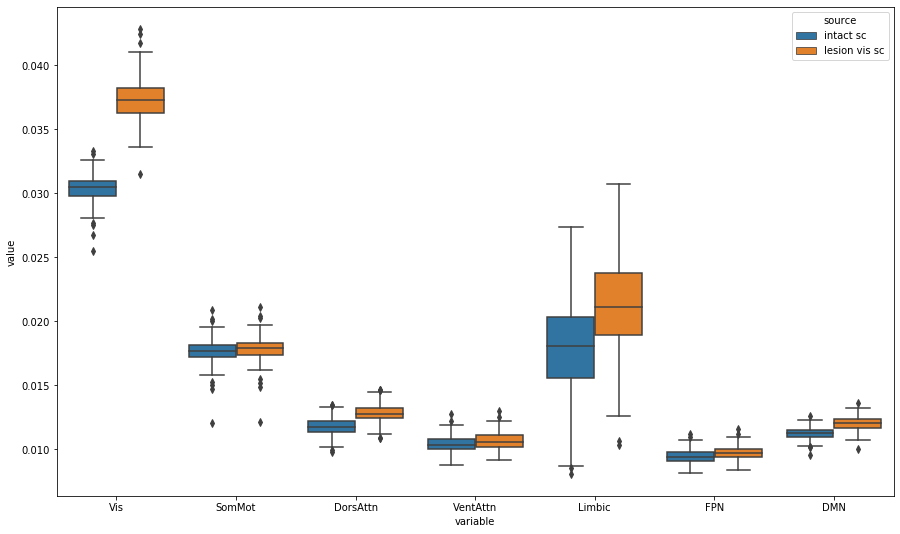

In [593]:
fig, ax = plt.subplots(figsize=(15,9))
ax = sns.boxplot(data=combined_df_long,x='variable',y='value',hue='source')


### bar plots

In [595]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

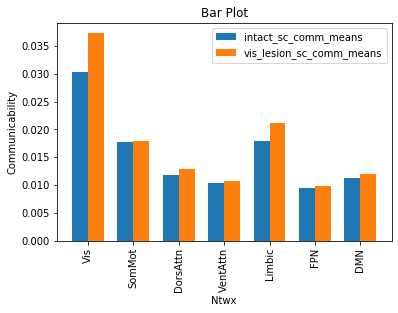

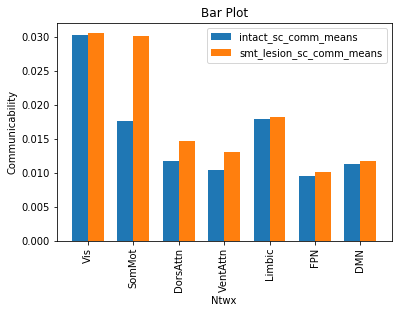

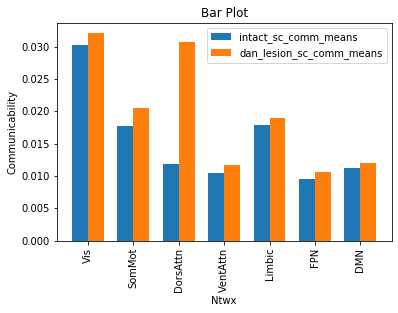

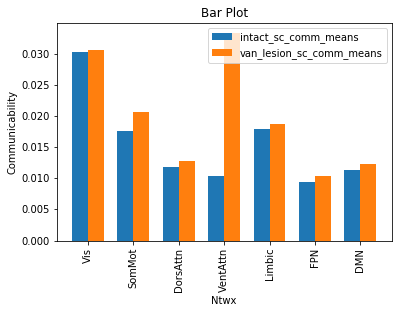

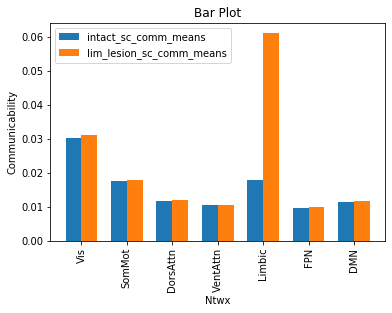

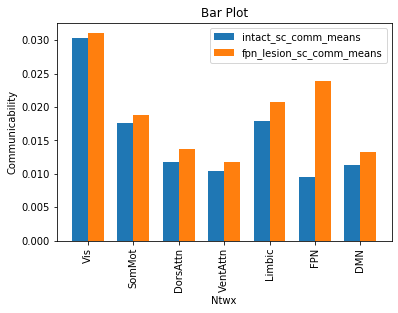

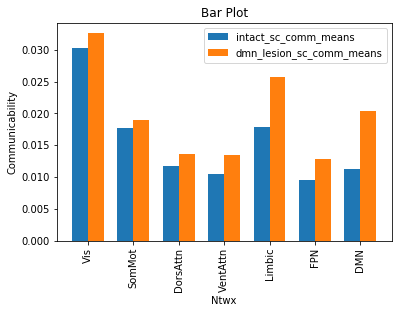

In [596]:
# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], vis_lesion_sc_comm_means, width, label='vis_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], smt_lesion_sc_comm_means, width, label='smt_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], dan_lesion_sc_comm_means, width, label='dan_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Ventattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], van_lesion_sc_comm_means, width, label='van_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Limbic

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], lim_lesion_sc_comm_means, width, label='lim_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], fpn_lesion_sc_comm_means, width, label='fpn_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means')
rects2 = ax.bar([i + width for i in x], dmn_lesion_sc_comm_means, width, label='dmn_lesion_sc_comm_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

## BETWEEN NTWX

In [620]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_sc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_sc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_sc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_sc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_sc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_sc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_sommot_sc, mean_ntwx_to_dorsattn_sc, mean_ntwx_to_ventattn_sc, mean_ntwx_to_limbic_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [622]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [690]:
def get_between_ntwx_sc_communicability_stats_version(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
#         ntwx_lesion_means_all_subs = [all_subs_vis_to_other_ntwx_lesions,all_subs_smt_to_other_ntwx_lesions,
#                                       all_subs_dan_to_other_ntwx_lesions,all_subs_van_to_other_ntwx_lesions,
#                                       all_subs_lim_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,
#                                       all_subs_dmn_to_other_ntwx_lesions]
        
    
    return all_subs_vis_to_other_ntwx_lesions,all_subs_smt_to_other_ntwx_lesions,all_subs_dan_to_other_ntwx_lesions,all_subs_van_to_other_ntwx_lesions,all_subs_lim_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [691]:
stats_intact_sc_vis_to_other_ntwx, stats_intact_sc_smt_to_other_ntwx, stats_intact_sc_dan_to_other_ntwx, stats_intact_sc_van_to_other_ntwx, stats_intact_sc_lim_to_other_ntwx, stats_intact_sc_fpn_to_other_ntwx, stats_intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_stats_version(all_subs_communicability_sc)


### intact SC

In [628]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.5 s, sys: 249 ms, total: 6.75 s
Wall time: 6.72 s


In [629]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [630]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

#### Visual 

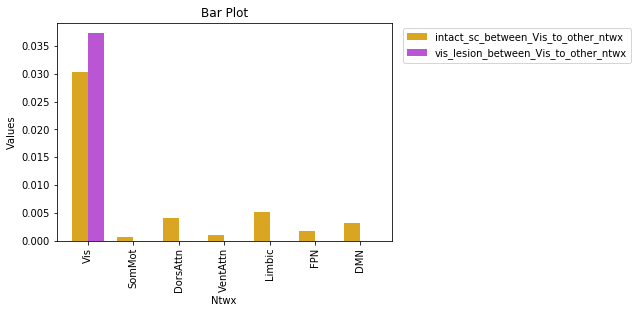

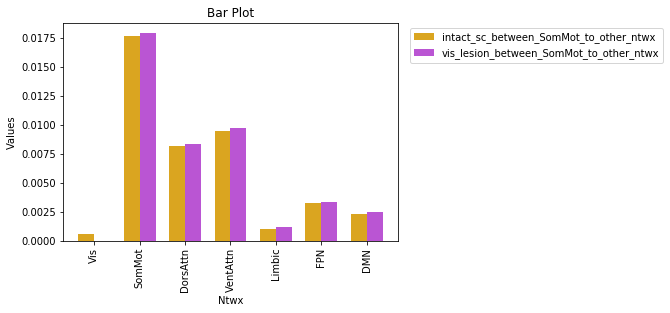

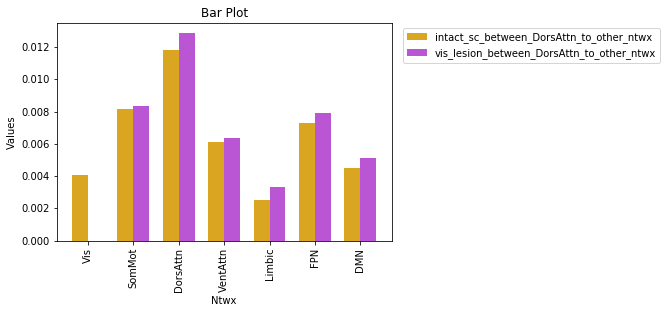

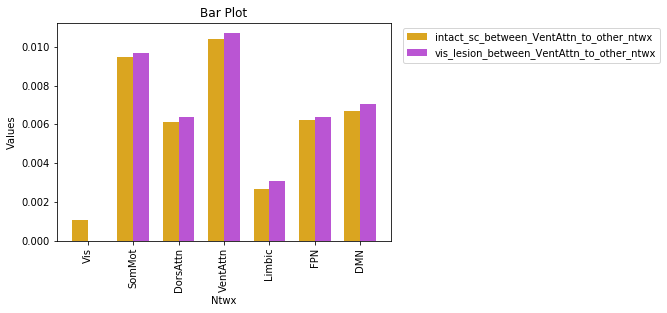

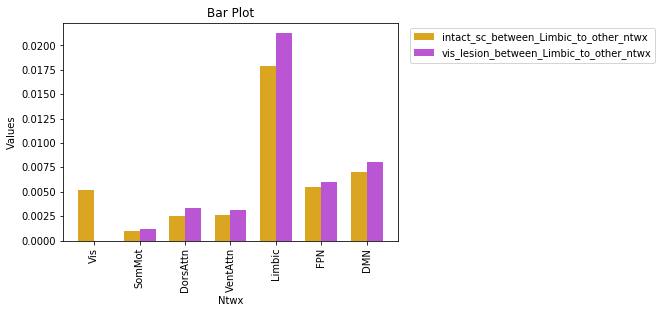

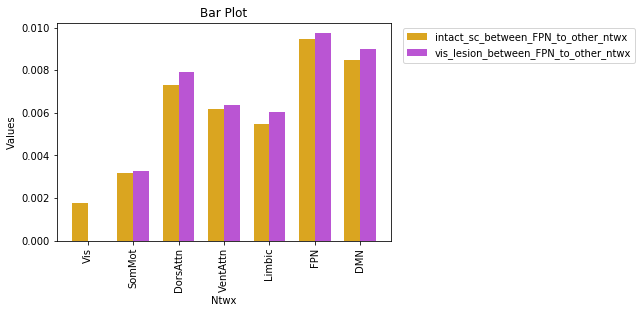

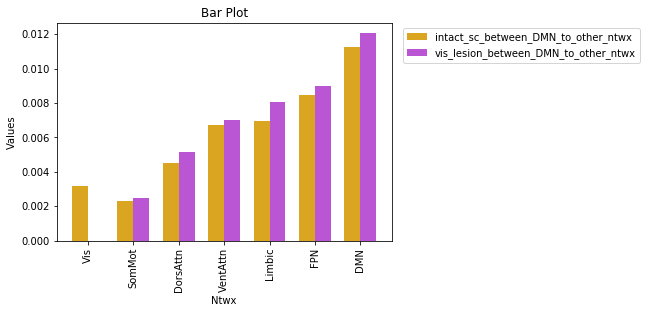

In [643]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], vis_lesion_between_other_ntwx[j], width, label='vis_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomatoMotor

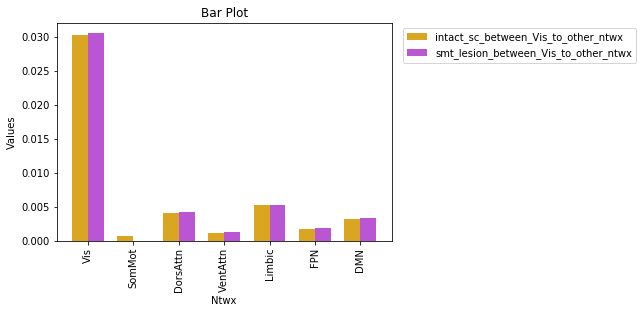

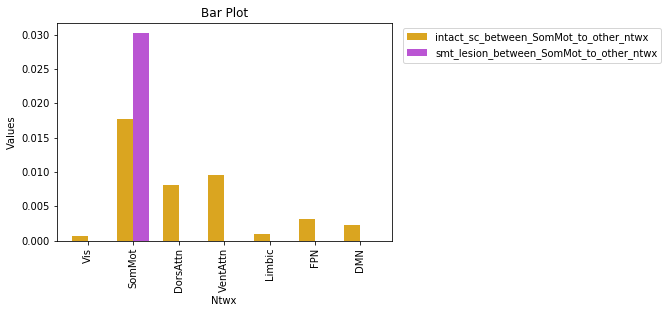

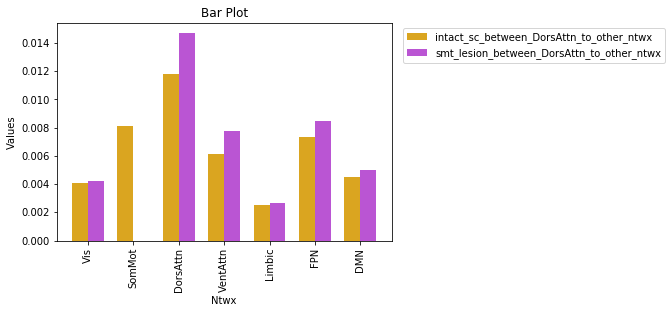

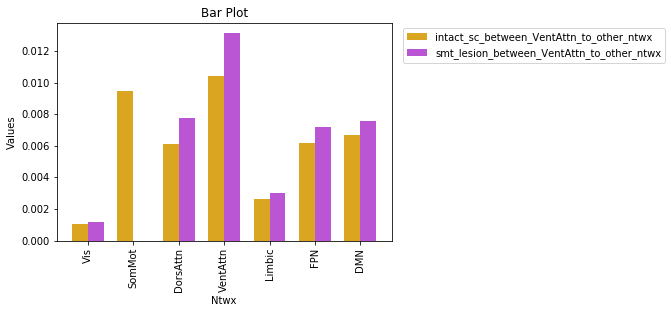

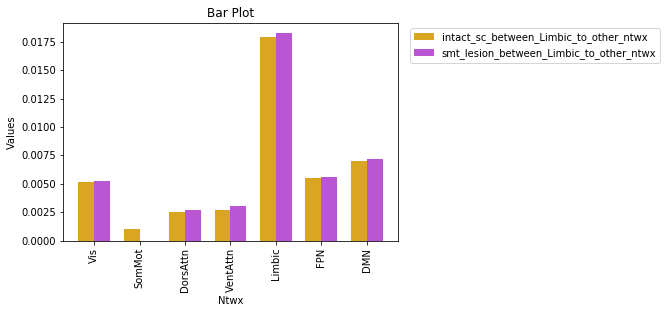

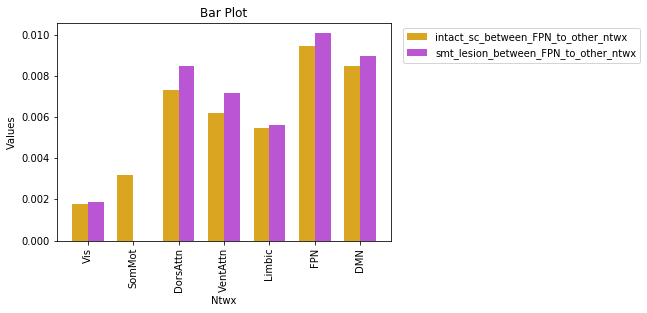

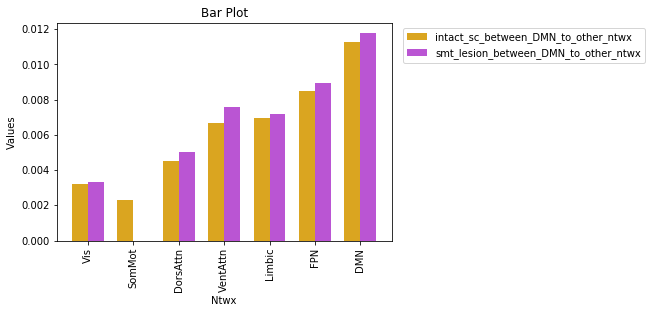

In [644]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], smt_lesion_between_other_ntwx[j], width, label='smt_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

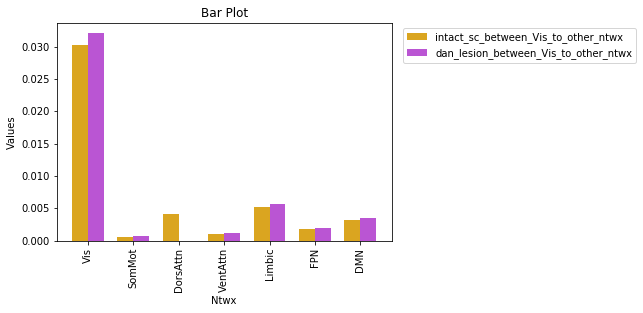

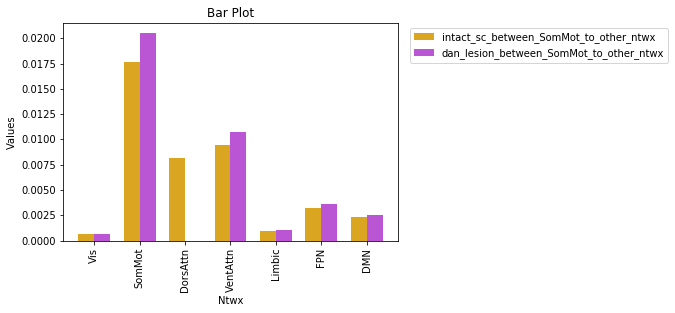

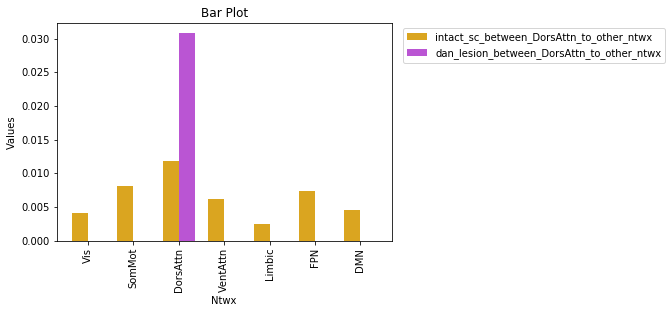

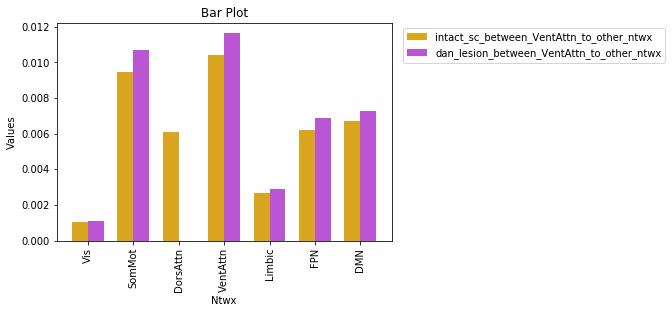

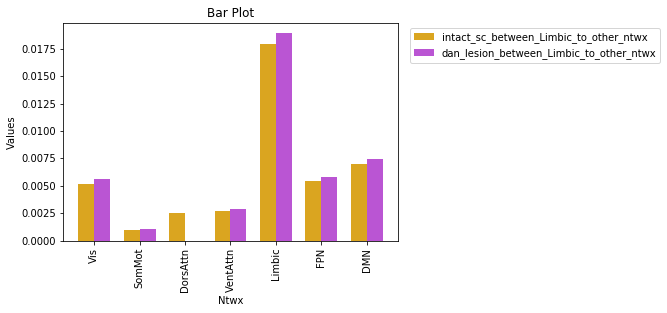

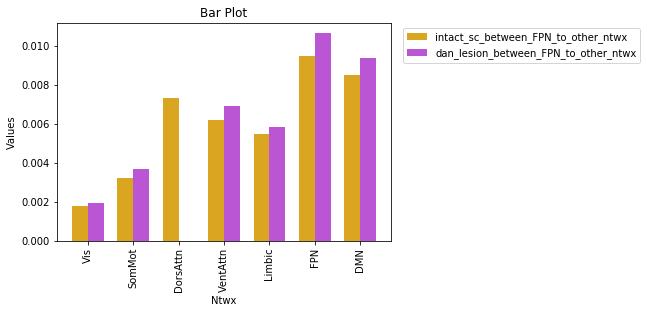

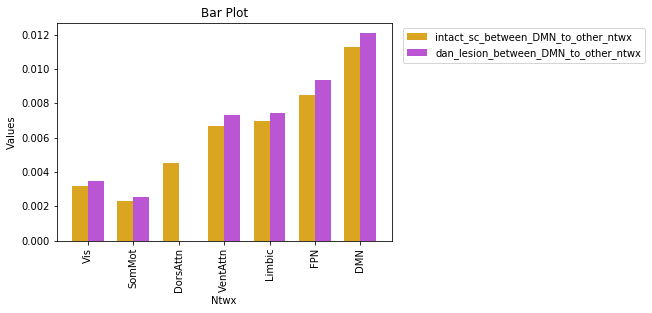

In [650]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dan_lesion_between_other_ntwx[j], width, label='dan_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VAN

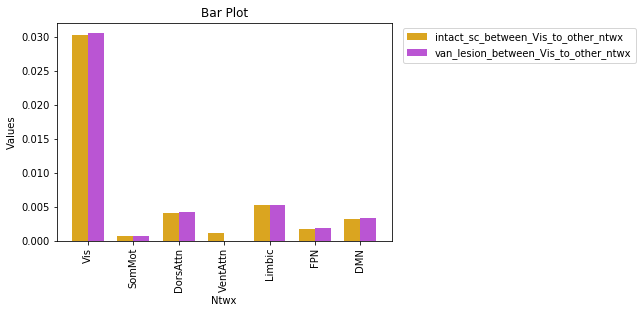

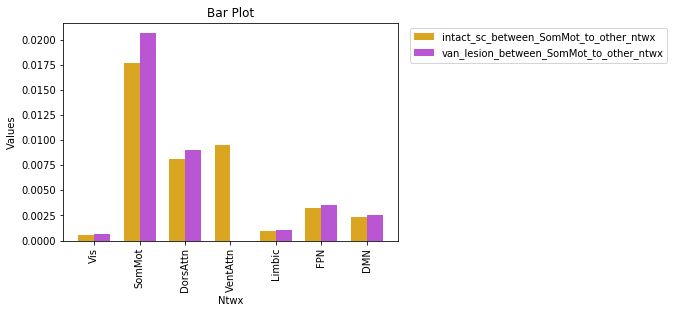

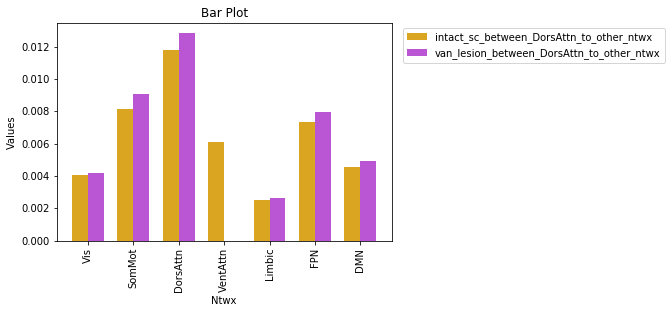

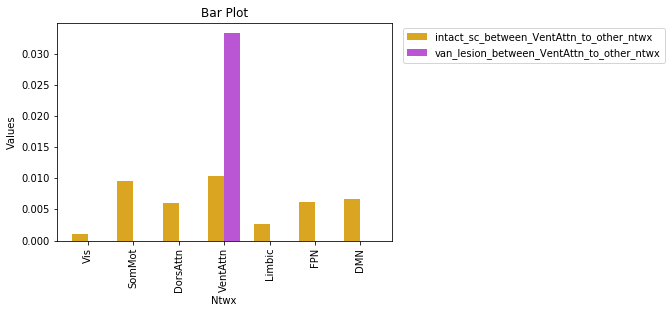

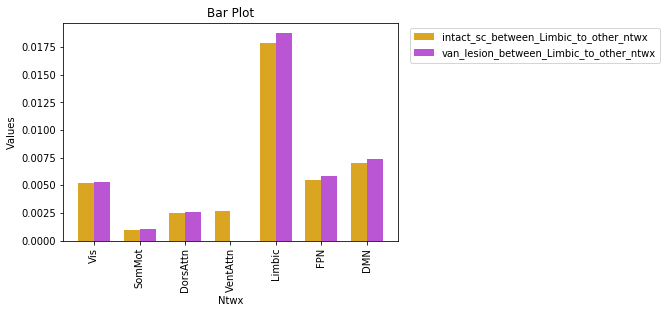

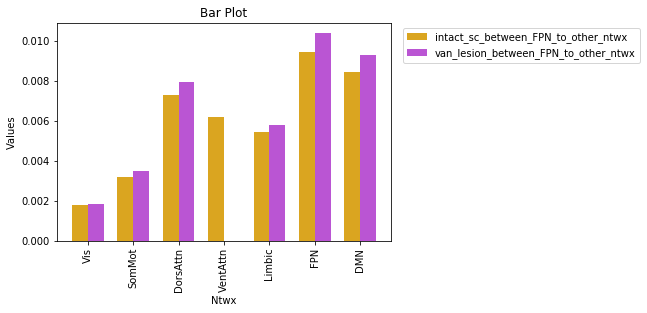

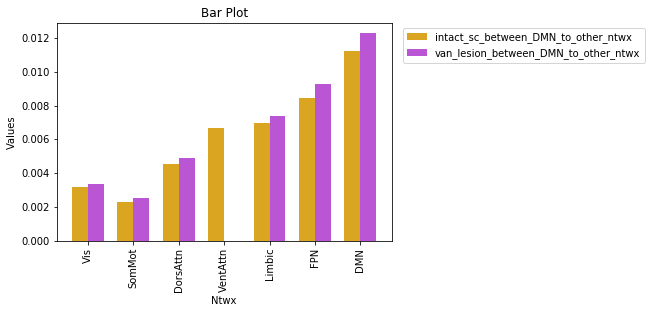

In [649]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], van_lesion_between_other_ntwx[j], width, label='van_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### lim

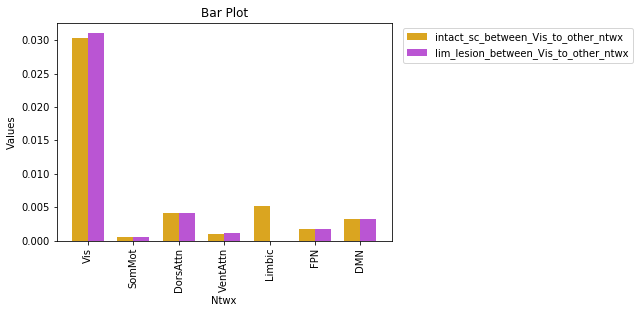

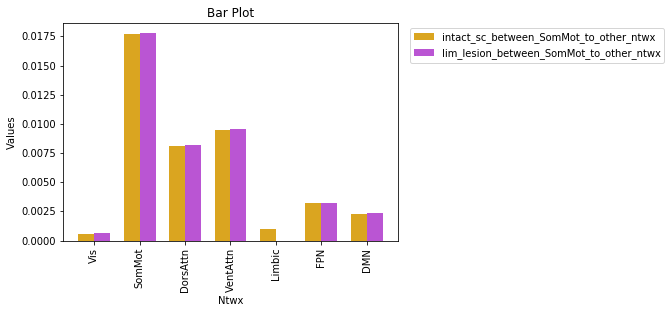

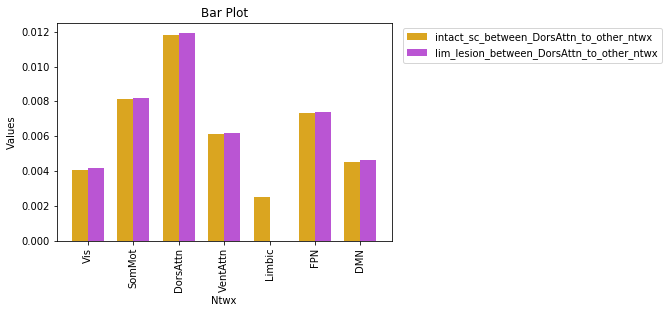

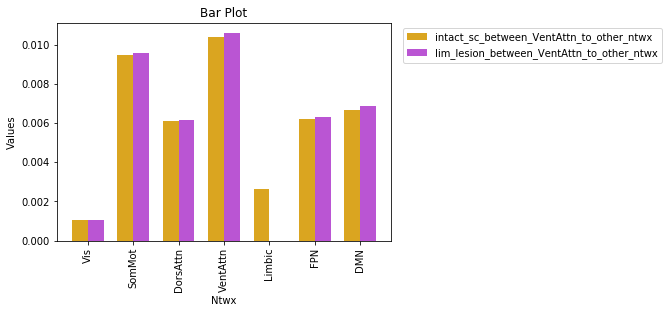

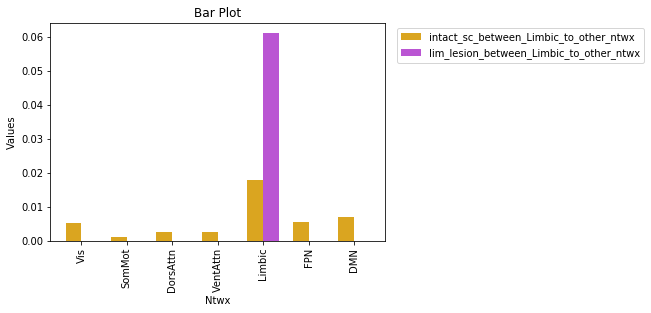

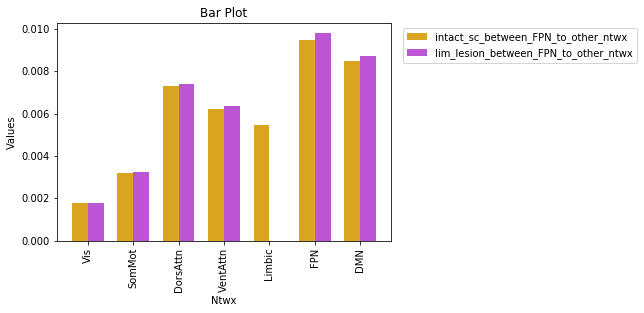

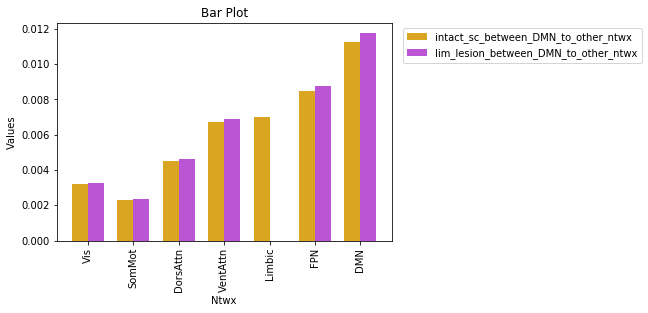

In [648]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], lim_lesion_between_other_ntwx[j], width, label='lim_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

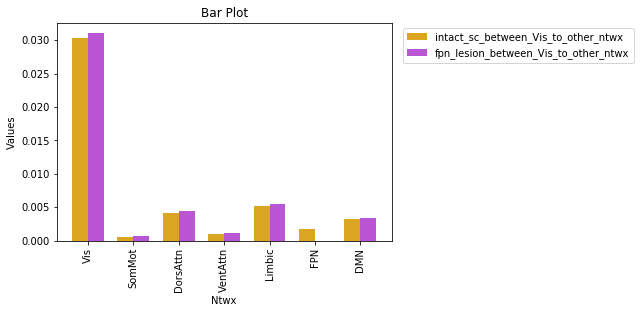

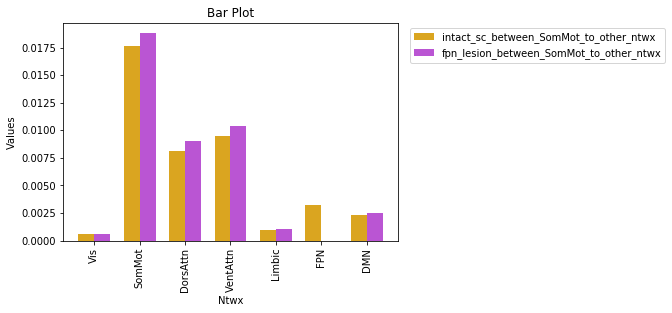

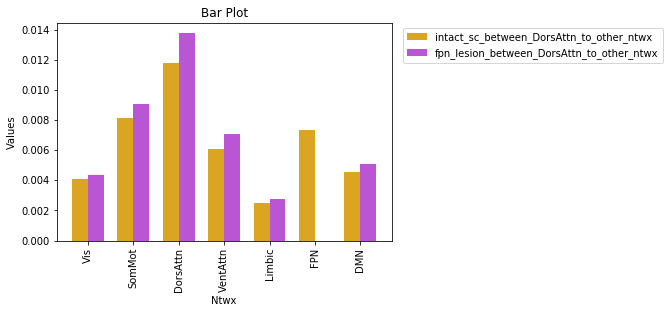

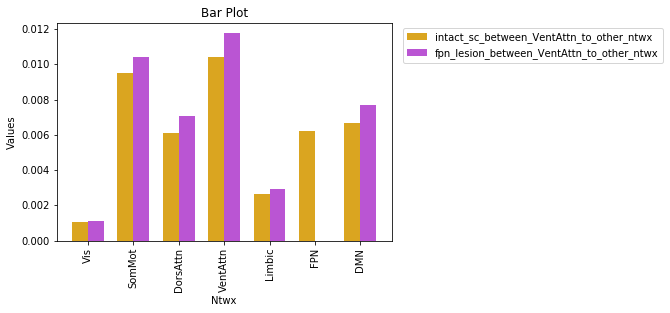

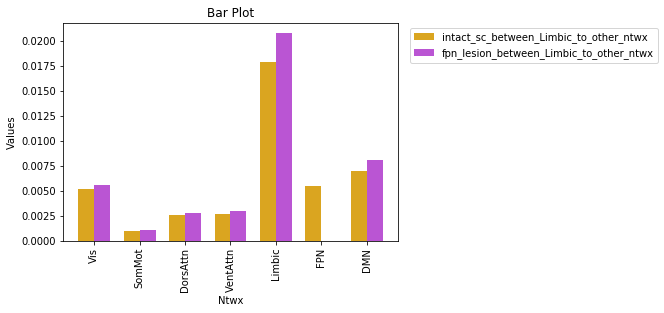

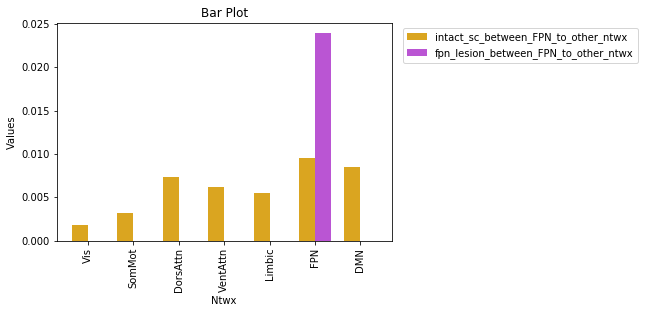

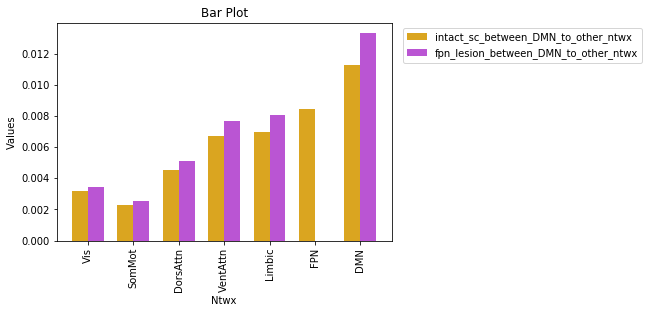

In [647]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], fpn_lesion_between_other_ntwx[j], width, label='fpn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

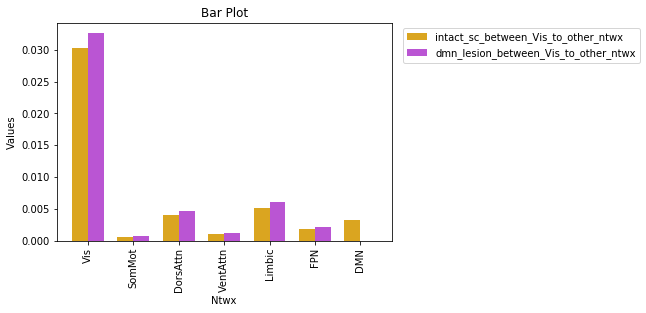

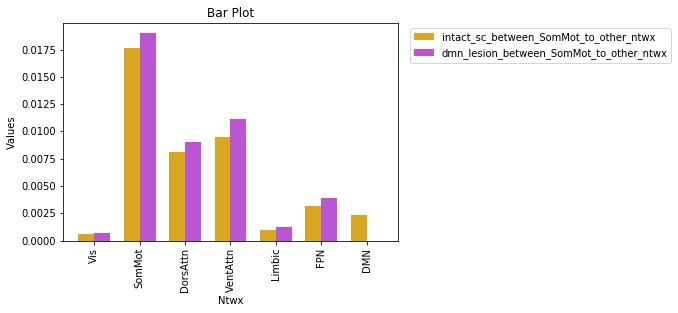

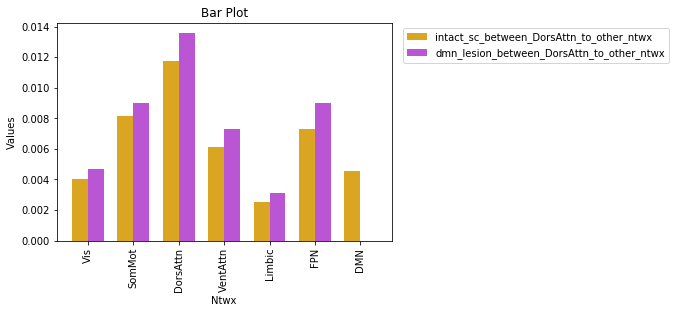

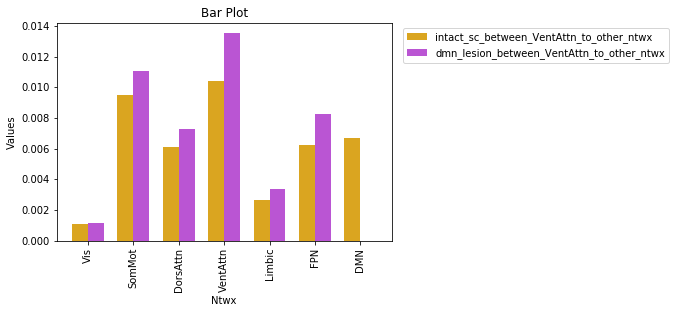

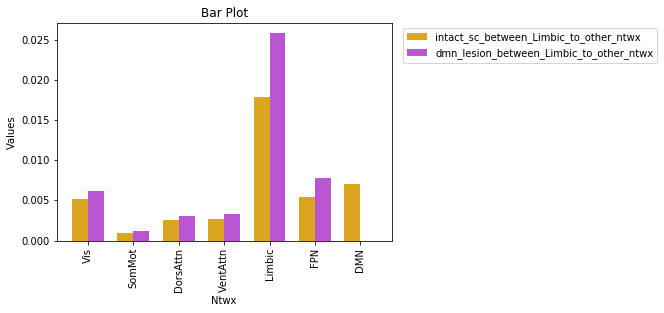

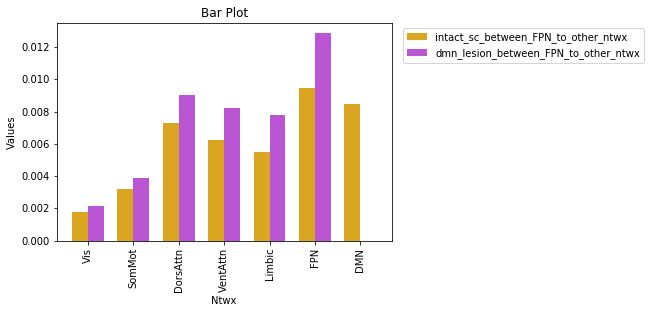

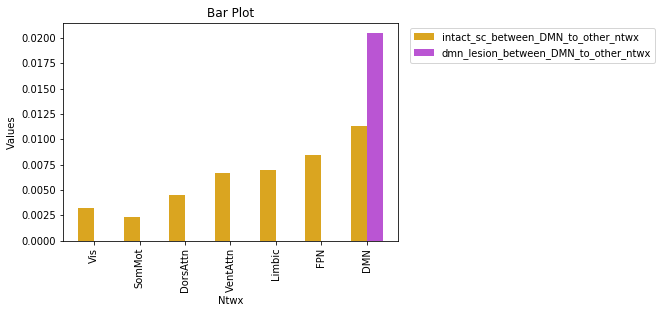

In [646]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dmn_lesion_between_other_ntwx[j], width, label='dmn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

In [544]:
# D = all_subs_pre_lap_SC[0]

In [545]:
# sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [31]:
# _test_comm_mtx = communicability_wei(all_subs_pre_lap_SC[0])

In [546]:
# _test_comm_mtx

In [547]:
# sns.heatmap(_test_comm_mtx,vmax=0.03)

#### Code Breakdown

```
    def communicability_wei(CIJ):
        N = CIJ.shape[0]
        B = np.sum(CIJ, axis=1)
        C = np.diag(B)
        D = np.linalg.inv(scipy.linalg.sqrtm(C))
        E = np.dot(np.dot(D, CIJ), D)
        F = scipy.linalg.expm(E)
        F = F * np.logical_not(np.eye(N))
    
        return F
    ```

In [503]:
# CIJ = D.copy()

# N = CIJ.shape[0]

# N

# B = np.sum(CIJ, axis=1)

# B

# C = np.diag(B)
# C

# # np.linalg.inv(np.sqrt(C))

# D1 = np.linalg.inv(np.sqrt(C))

# D1

# E = np.dot(np.dot(D1, CIJ), D1)

# E

# F = scipy.linalg.expm(E)

# F

# F = F * ~np.eye(N, dtype=bool)

# F

### For a lesioned SC

In [509]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

In [532]:
# Visual network 

vis_sc_lesion = structurally_isolate_func_ntwx(0,14,100,115, all_subs_pre_lap_SC[0])

In [612]:
sns.heatmap(np.log1p(dmn_sc_lesion))

NameError: name 'dmn_sc_lesion' is not defined

In [535]:
_test_comm_mtx_vis_lesion = communicability_wei(vis_sc_lesion)

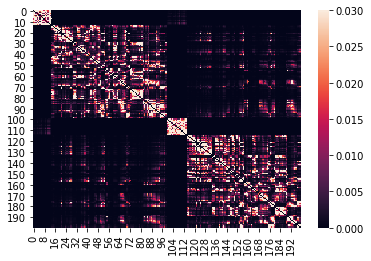

In [537]:
sns.heatmap(_test_comm_mtx_vis_lesion,vmax=0.03)

In [531]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_sc

In [540]:
within_ntwx_vis_intact_sc = within_ntwx_SC(_test_comm_mtx, 0,14,100,115)

In [541]:
within_ntwx_vis_lesion_sc = within_ntwx_SC(_test_comm_mtx_vis_lesion, 0,14,100,115)

In [599]:
_test_comm_mtx

array([[0.        , 0.14858583, 0.03520457, ..., 0.00118658, 0.00067846,
        0.00082001],
       [0.14858583, 0.        , 0.08866112, ..., 0.00165178, 0.00080428,
        0.00090207],
       [0.03520457, 0.08866112, 0.        , ..., 0.00106726, 0.00052072,
        0.00069288],
       ...,
       [0.00118658, 0.00165178, 0.00106726, ..., 0.        , 0.17384561,
        0.05939909],
       [0.00067846, 0.00080428, 0.00052072, ..., 0.17384561, 0.        ,
        0.21446142],
       [0.00082001, 0.00090207, 0.00069288, ..., 0.05939909, 0.21446142,
        0.        ]])

In [600]:
_test_comm_mtx_vis_lesion

array([[0.        , 0.18709051, 0.04694347, ..., 0.        , 0.        ,
        0.        ],
       [0.18709051, 0.        , 0.11191106, ..., 0.        , 0.        ,
        0.        ],
       [0.04694347, 0.11191106, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.20742961,
        0.07143399],
       [0.        , 0.        , 0.        , ..., 0.20742961, 0.        ,
        0.22363709],
       [0.        , 0.        , 0.        , ..., 0.07143399, 0.22363709,
        0.        ]])

In [602]:
all_subs_pre_lap_SC[0]

array([[ 6948,  3809,   535, ...,    10,     7,     6],
       [ 3809, 27742,  2447, ...,    28,    15,    13],
       [  535,  2447, 10962, ...,    14,     6,     7],
       ...,
       [   10,    28,    14, ..., 11732,  4734,   901],
       [    7,    15,     6, ...,  4734, 31182,  5152],
       [    6,    13,     7, ...,   901,  5152,  6826]])

In [601]:
all_subs_sc_vis_lesion[0]

array([[ 6948,  3809,   535, ...,     0,     0,     0],
       [ 3809, 27742,  2447, ...,     0,     0,     0],
       [  535,  2447, 10962, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 11732,  4734,   901],
       [    0,     0,     0, ...,  4734, 31182,  5152],
       [    0,     0,     0, ...,   901,  5152,  6826]])

In [699]:
G = nx.Graph(1/(all_subs_pre_lap_SC[1]))

# Choose source and target nodes
source_node = 67
target_node = 13

# Find shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

print(shortest_path, '\n')

for i in range(len(shortest_path)):
    print(labels[shortest_path[i]])


print('\n')
print('Total Hops = ', len(shortest_path)-1)

[67, 92, 61, 81, 7, 10, 13] 

7Networks_LH_Cont_PFCl_3
7Networks_LH_Default_PFC_11
7Networks_LH_Cont_Par_2
7Networks_LH_Default_Par_4
7Networks_LH_Vis_8
7Networks_LH_Vis_11
7Networks_LH_Vis_14


Total Hops =  6


In [701]:
G = nx.Graph(1/(all_subs_sc_dmn_lesion[1]))

# Choose source and target nodes
source_node = 67
target_node = 13

# Find shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

print(shortest_path, '\n')

for i in range(len(shortest_path)):
    print(labels[shortest_path[i]])


print('\n')
print('Total Hops = ', len(shortest_path)-1)

[67, 68, 31, 7, 10, 13] 

7Networks_LH_Cont_PFCl_3
7Networks_LH_Cont_PFCl_4
7Networks_LH_DorsAttn_Post_2
7Networks_LH_Vis_8
7Networks_LH_Vis_11
7Networks_LH_Vis_14


Total Hops =  5


## Shortest Distance
### Using `networkx` 

In [702]:
D = all_subs_pre_lap_SC[34]

In [703]:
G = nx.Graph(1/D)

# Choose source and target nodes
source_node = 0
target_node = 155

# Find shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

print(shortest_path, '\n')

for i in range(len(shortest_path)):
    print(labels[shortest_path[i]])


print('\n')
print('Total Hops = ', len(shortest_path)-1)

[0, 12, 13, 10, 7, 79, 81, 92, 93, 94, 155] 

7Networks_LH_Vis_1
7Networks_LH_Vis_13
7Networks_LH_Vis_14
7Networks_LH_Vis_11
7Networks_LH_Vis_8
7Networks_LH_Default_Par_2
7Networks_LH_Default_Par_4
7Networks_LH_Default_PFC_11
7Networks_LH_Default_PFC_12
7Networks_LH_Default_PFC_13
7Networks_RH_SalVentAttn_Med_1


Total Hops =  10


In [695]:
G = nx.Graph(1/D)

# Choose source and target nodes
source_node = 0
target_node = 155

# Find shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

print(shortest_path, '\n')

for i in range(len(shortest_path)):
    print(labels[shortest_path[i]])


print('\n')
print('Total Hops = ', len(shortest_path)-1)

[0, 1, 6, 12, 95, 96, 51, 53, 157, 155] 

7Networks_LH_Vis_1
7Networks_LH_Vis_2
7Networks_LH_Vis_7
7Networks_LH_Vis_13
7Networks_LH_Default_pCunPCC_1
7Networks_LH_Default_pCunPCC_2
7Networks_LH_SalVentAttn_Med_1
7Networks_LH_SalVentAttn_Med_3
7Networks_RH_SalVentAttn_Med_3
7Networks_RH_SalVentAttn_Med_1


Total Hops =  9


In [704]:
G = nx.Graph(1/D)

# Choose source and target nodes
source_node = 64
target_node = 121

# Find shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

print(shortest_path, '\n')

for i in range(len(shortest_path)):
    print(labels[shortest_path[i]])


print('\n')
print('Total Hops = ', len(shortest_path)-1)

[64, 82, 85, 193, 194, 195, 175, 146, 121] 

7Networks_LH_Cont_OFC_1
7Networks_LH_Default_PFC_1
7Networks_LH_Default_PFC_4
7Networks_RH_Default_PFCdPFCm_4
7Networks_RH_Default_PFCdPFCm_5
7Networks_RH_Default_PFCdPFCm_6
7Networks_RH_Cont_PFCl_7
7Networks_RH_DorsAttn_PrCv_1
7Networks_RH_SomMot_7


Total Hops =  8


# --------------------------------------------------------------------------------------------------------------

## Extra stuff 

### Symmetric

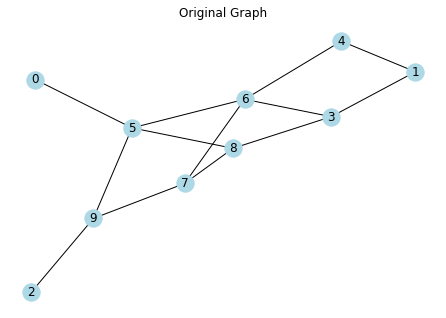

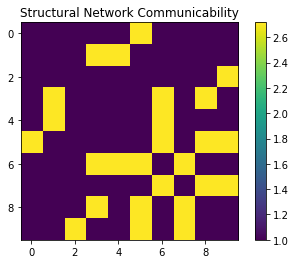

In [396]:
# Create a random graph (you can replace this with your own graph)
G = nx.erdos_renyi_graph(10, 0.3)

# Calculate the adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Calculate the matrix exponential of the adjacency matrix
communicability_matrix = np.exp(adj_matrix)

# Visualize the original graph
pos = nx.spring_layout(G, seed=665)
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.title("Original Graph")
plt.show()

# Visualize the communicability matrix
plt.imshow(communicability_matrix, cmap='viridis', origin='upper')
plt.colorbar()
plt.title("Structural Network Communicability")
plt.show()

### Asymmetric

In [402]:
# Replace this with your 10x10 directed connectivity matrix
# Example matrix with random values:
connectivity_matrix = np.random.randint(0, 2, size=(10, 10))

In [403]:
connectivity_matrix

array([[1, 1, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 1, 0, 1, 0, 1, 1]])

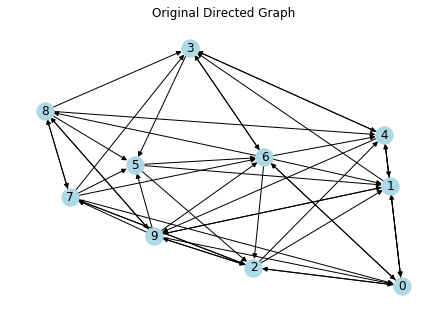

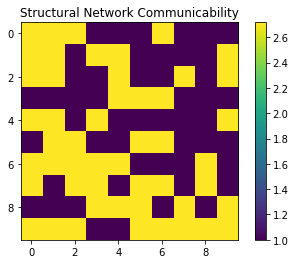

In [401]:
# Calculate the matrix exponential of the directed connectivity matrix
communicability_matrix = np.exp(connectivity_matrix)

# Create a NetworkX directed graph from the connectivity matrix
G = nx.DiGraph(connectivity_matrix)

# Visualize the original directed graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.title("Original Directed Graph")
plt.show()

# Visualize the communicability matrix
plt.imshow(communicability_matrix, cmap='viridis', origin='upper')
plt.colorbar()
plt.title("Structural Network Communicability")
plt.show()